In [1]:
from pytket import Circuit, OpType
import numpy as np


def _string_to_indices(bitstring: str) -> list:
    """
    Helper function: Given an input bitstring returns a list of qubit indices
    on which to apply X gates in step 1.
    """
    index_list = []

    for count, bit in enumerate(bitstring):
        if bit == "0":
            index_list.append(count)

    return index_list

In [2]:
def grover_oracle_circuit(bitstring: str) -> Circuit:
    """
    Builds a circuit which performs the grover oracle. Takes a bitstring representation
    of a basis state as input and produces the circuit for marking the basis state in the superposition.
    """
    n_qubits = len(bitstring)
    circ = Circuit(n_qubits)

    x_indices = _string_to_indices(
        bitstring
    )  # List of indices where we apply a Pauli X gate

    for j in x_indices:  # First layer of Pauli gates
        circ.X(j)

    circ.add_gate(OpType.CnZ, list(range(n_qubits)))

    for k in x_indices:  # Second layer of Pauli gates
        circ.X(k)

    return circ

In [3]:
def grover_diffusion_circuit(n_qubits: int) -> Circuit:
    """
    Constructs a circuit that returns the Grover diffusion operator for a given number of qubits.
    """

    circ = Circuit(n_qubits)

    for j in range(n_qubits):
        circ.H(j)
        circ.X(j)

    circ.add_gate(OpType.CnZ, list(range(n_qubits)))

    for k in range(n_qubits):
        circ.X(k)
        circ.H(k)

    return circ

In [4]:
def build_grover_circuit(bitstring: str, n_iters: int) -> Circuit:
    """
    Constructs a Grover's circuit for a specified computational basis state and number of iterations.
    """
    n_qubits = len(bitstring)
    circ = Circuit(n_qubits)

    # prepare uniform superposition
    for j in range(n_qubits):
        circ.H(j)

    # repeat the marking and diffusion steps n_iters times
    for k in range(n_iters):
        circ.append(grover_oracle_circuit(bitstring))
        circ.append(grover_diffusion_circuit(n_qubits))

    # measure all qubits
    circ.measure_all()

    return circ

In [5]:
# experiment parameters
binary_string = "10011"
n_shots = 1000
n_iters = 3

grover_circuit_exp = build_grover_circuit(binary_string, n_iters=n_iters)


# calculate optimal number of iterations for a given problem size
def optimial_iteration_number(n_qubits: int, m_solutions=1):
    """
    Returns the theoretically optimal number of Grover iterations given the
    size of the problem and the number of solutions.
    """
    N = 2**n_qubits
    ans = np.floor(np.pi / 4 * np.sqrt(N / m_solutions) - 1 / 2)
    return int(ans)


n_qubits = len(binary_string)
opt = optimial_iteration_number(n_qubits)
print(f"The optimal number of Grover iterations is {opt}.")

The optimal number of Grover iterations is 3.


In [6]:
from pytket.extensions.qiskit import AerBackend

backend = AerBackend()  # initalise noiseless Aer simulator

compiled_circ = backend.get_compiled_circuit(grover_circuit_exp)
print(f"Number of quantum gates = {compiled_circ.n_gates}.")
print(f"Number of CX gates = {compiled_circ.depth_by_type(OpType.CX)}.")


handle = backend.process_circuit(compiled_circ, n_shots=n_shots)
grover_result = backend.get_result(handle)

Number of quantum gates = 468.
Number of CX gates = 210.


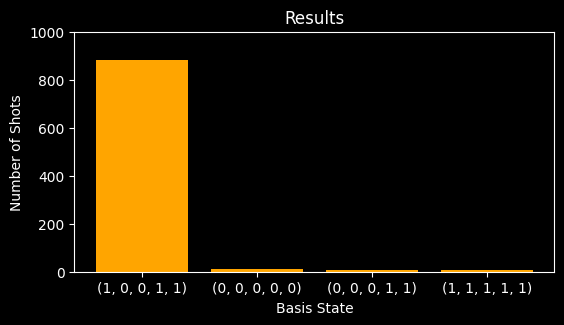

Counter({(1, 0, 0, 1, 1): 883, (0, 0, 0, 0, 0): 11, (0, 0, 0, 1, 1): 8, (1, 1, 1, 1, 1): 7, (1, 0, 1, 0, 1): 6, (0, 0, 1, 0, 0): 5, (0, 1, 0, 1, 1): 5, (1, 0, 0, 0, 0): 5, (1, 1, 1, 0, 0): 5, (0, 0, 0, 0, 1): 4, (0, 0, 1, 0, 1): 4, (0, 1, 0, 1, 0): 4, (0, 1, 1, 0, 0): 4, (1, 0, 1, 1, 1): 4, (1, 1, 0, 0, 0): 4, (1, 1, 0, 1, 1): 4, (1, 1, 1, 1, 0): 4, (0, 0, 0, 1, 0): 3, (0, 0, 1, 1, 0): 3, (0, 1, 0, 0, 1): 3, (0, 1, 1, 1, 1): 3, (1, 0, 0, 1, 0): 3, (1, 0, 1, 1, 0): 3, (1, 1, 1, 0, 1): 3, (0, 0, 1, 1, 1): 2, (0, 1, 1, 0, 1): 2, (0, 1, 1, 1, 0): 2, (1, 0, 1, 0, 0): 2, (0, 1, 0, 0, 0): 1, (1, 0, 0, 0, 1): 1, (1, 1, 0, 0, 1): 1, (1, 1, 0, 1, 0): 1})


In [8]:
from plotting import plot_results

plot_results(grover_result, dark_mode=True, y_limit=1000)
print(grover_result.get_counts())